# Overview

This notebook trains 5 models using *tags* as the feature, including 1 regression model (Ridge Regression) and 4 classification models (Logistic Classification, Decision Tree, Adaboost, and SVM).

We first start with the preprocessing steps of loading the dataframes and transforming certain columns so they can be used directly.

Then, we proceed to model trainings and interpreting variable importances.

# Preprocessing

In [ ]:
# load imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import plotly.express as px
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import json
import matplotlib.pyplot as plt

In [ ]:
train_df = pd.read_csv('drive/MyDrive/CIS520 Project/data set/train_name_pos_tag.csv')
test_df = pd.read_csv('drive/MyDrive/CIS520 Project/data set/test_name_pos_tag.csv')
test_df_upsampled = pd.read_csv('drive/MyDrive/CIS520 Project/data set/test_df_upsampled.csv')

def parse_json(df):
  df['authors'] = df['authors'].apply(lambda x : json.loads(x))
  df['tags'] = df['tags'].apply(lambda x : json.loads(x))
  df['author_positions'] = df['author_positions'].apply(lambda x : json.loads(x))
  return df

train_df = parse_json(train_df)
test_df = parse_json(test_df)
test_df_upsampled = parse_json(test_df_upsampled)

In [ ]:
# combine author names, tags, author positions into 
# a comma separted string

def transform_meta(df):
  cols = ['authors', 'tags', 'author_positions']
  for col in cols:
    df[col] = df[col].apply(lambda x : ', '.join(x))
  
  return df

train_df = transform_meta(train_df)
test_df = transform_meta(test_df)
test_df_upsampled = transform_meta(test_df_upsampled)

In [ ]:
# get quintiles for train data
train_df['quintile'] = pd.cut(train_df['percentile'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [1,2,3,4,5])
# get quintiles for the test data
test_df['quintile'] = pd.cut(test_df['percentile'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [1,2,3,4,5])

# Get top 25% vs bottom 75%
train_df['top25pct'] = (train_df['percentile'] >= 0.75).astype(int)
test_df['top25pct'] = (test_df['percentile'] >= 0.75).astype(int)

train_df['published_date'] = train_df['published_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test_df['published_date'] = test_df['published_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [ ]:
# Returns the training and test data within the window
def get_window(train_df, test_df, date_start, months):
  date_end = date_start + relativedelta(months = +months)
  train_window = train_df.loc[(train_df['published_date'] >= date_start) & (train_df['published_date'] < date_end), :]
  test_window = test_df.loc[(test_df['published_date'] >= date_start) & (test_df['published_date'] < date_end), :]
  return train_window, test_window

In [ ]:
def upsample_minority(df):

  # Upsample minority class in both the training and test data
  df_majority = df.loc[df['top25pct'] == 0, :]
  df_minority = df.loc[df['top25pct'] == 1, :]
  df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

  # Combine together to get the upsampled training data
  df = pd.concat([df_majority, df_minority_upsampled])

  return df

**Count Vectorization of Words**

In [ ]:
# Input: train, test dataframe, feature
# Output: train_titles, test_titles vectorized matrix (#doc x #words)
def convert_text_to_vectors(train_data, test_data, max_words = 2000, use_tfidf = False):

  # Doing the Vectorization of the text
  if use_tfidf == False:
    vectorizer = CountVectorizer(stop_words='english', max_features = max_words)
  else:
    vectorizer = TfidfVectorizer(stop_words = 'english', max_features = max_words)

  # tokenize and build vocab
  vectorizer.fit(train_data['tags'])

  # transform text columns
  X_train = vectorizer.transform(train_data['tags']).toarray()
  X_test = vectorizer.transform(test_data['tags']).toarray()

  return X_train, X_test, vectorizer

# Model Trainings

## Ridge Regression

Regression model on percentiles

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

In [ ]:
# Create and fit model

def train_ridge(X_train, X_test, y_train, y_test, alpha = 1):
  reg = Ridge(alpha = alpha)
  reg.fit(X_train, y_train)
  y_train_pred = reg.predict(X_train)
  
  # Training MSE and MAE
  rmse = mean_squared_error(y_train, y_train_pred) ** 0.5
  mae = mean_absolute_error(y_train, y_train_pred)

  print('Training RMSE: {}, MAE: {}'.format(rmse , mae))

  # Fit on test data
  y_test_pred = reg.predict(X_test)
  # Training MSE and MAE
  rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
  mae = mean_absolute_error(y_test, y_test_pred)
  print('Test RMSE: {}, MAE: {}'.format(rmse , mae))

  return y_train_pred, y_test_pred, reg

In [ ]:
# Variable Importance

def get_variable_importance(reg, vectorizer, X_train_titles):

  reg_coefs = reg.coef_
  vectorizer_words = vectorizer.get_feature_names()

  word_coefs = {}
  for word, coef in zip(vectorizer_words, reg_coefs):
    word_coefs.update({word:coef})

  # Word Frequency
  word_freq = np.sum(X_train_titles, axis = 0)
  # Number of articles the word appeared in
  word_num_articles = np.sum((X_train_titles > 0).astype(int), axis = 0)

  # Store the top words in a dataframe
  word_coefs_df = pd.DataFrame({'Word': vectorizer_words, 'Frequency': word_freq, 'Articles': word_num_articles, 'Coef': reg_coefs}).sort_values('Coef', ascending = False).reset_index(drop = True)

  return word_coefs_df

In [ ]:
# Run Model on All

# Vectorize words
X_train, X_test, vec = convert_text_to_vectors(train_df, test_df_upsampled, max_words = 2000, use_tfidf = False)
y_percentiles_train = train_df['percentile']
y_percentiles_test = test_df_upsampled['percentile']

# Train ridge regression
y_train_pred, y_test_pred, reg = train_ridge(X_train, X_test, y_percentiles_train, y_percentiles_test, alpha = 20)

Training RMSE: 0.22484518053477662, MAE: 0.18440923249719746
Test RMSE: 0.24465097002845976, MAE: 0.20742336748889548


In [ ]:
# examine variable importance

# Get the variable importance coefs
word_coefs_df = get_variable_importance(reg, vec, X_train)

# Only choose words appearing more than 50 times
word_coefs_df_top = word_coefs_df.loc[word_coefs_df['Frequency'] > 50, :]

word_coefs_df_top.head(50)

Text(0.5, 1.0, 'Variable Importances for Tags')

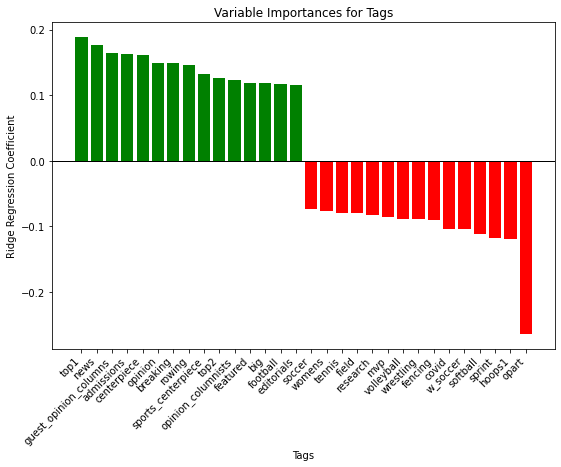

In [ ]:
fig = plt.figure(figsize = (9, 6))

plt.bar(word_coefs_df_top.iloc[0:15, 0], word_coefs_df_top.iloc[0:15, -1], color = 'green')
plt.bar(word_coefs_df_top.iloc[-15:, 0], word_coefs_df_top.iloc[-15:, -1], color = 'red')
fig = plt.xticks(rotation=45, ha="right")
plt.axhline(y = 0, color = 'black', linewidth = 1)
plt.xlabel('Tags')
plt.ylabel('Ridge Regression Coefficient')
plt.title('Variable Importances for Tags')

In [ ]:
# Save the predictions to be used for ensemble
test_df_upsampled['ridge_predictions_tags'] = y_test_pred

**Rolling Window Predictions**

In [ ]:
# Get a list of start dates
dates = [datetime.fromtimestamp(e.timestamp()) for e in pd.date_range('2013-01-01','2020-05-02', freq='MS')]

word_coefs_df_all = pd.DataFrame()
for start_date in dates:
  print(start_date)
  # Segment by window
  train_window, test_window = get_window(train_df, test_df, start_date, 3)
  # Vectorize words
  X_train, X_test, vec = convert_text_to_vectors(train_window, test_window, max_words = 2000, use_tfidf = False)
  
  y_percentiles_train = train_window['percentile']
  y_percentiles_test = test_window['percentile']
  # Train ridge regression
  y_train_pred, y_test_pred, reg = train_ridge(X_train, X_test, y_percentiles_train, y_percentiles_test, alpha = 20)

  # Get the variable importance coefs
  word_coefs_df = get_variable_importance(reg, vec, X_train)

  word_coefs_df['Month'] = start_date

  word_coefs_df_all = pd.concat([word_coefs_df_all, word_coefs_df], axis = 0)

2013-01-01 00:00:00
Training RMSE: 0.19125364031089806, MAE: 0.15754372375401424
Test RMSE: 0.21845869461395348, MAE: 0.18469895860975105
2013-02-01 00:00:00
Training RMSE: 0.18853265161259253, MAE: 0.154182231577569
Test RMSE: 0.22732943134520878, MAE: 0.19001606201792162
2013-03-01 00:00:00
Training RMSE: 0.187997939655866, MAE: 0.15476945100078474
Test RMSE: 0.22100151576098506, MAE: 0.18511403854633218
2013-04-01 00:00:00
Training RMSE: 0.20851142550000631, MAE: 0.17342722693965032
Test RMSE: 0.26482963894584116, MAE: 0.2293902345493854
2013-05-01 00:00:00
Training RMSE: 0.23046945420158568, MAE: 0.19699968595618067
Test RMSE: 0.3111921764450392, MAE: 0.2692177123859449
2013-06-01 00:00:00
Training RMSE: 0.22501310891044699, MAE: 0.1912253626069458
Test RMSE: 0.29462205713494544, MAE: 0.23991518023216396
2013-07-01 00:00:00
Training RMSE: 0.20784120483919788, MAE: 0.17098319908925919
Test RMSE: 0.2436530671510532, MAE: 0.192464961806437
2013-08-01 00:00:00
Training RMSE: 0.21662394

In [ ]:
top_words=  word_coefs_df_all.groupby('Word')['Frequency'].sum().sort_values(ascending = False).iloc[0:30].index.tolist()


In [ ]:
top_words_filtered = ['sports', 'news', 'topstories', 'newsreel', 'opinion', 'centerpiece', 'politics', 'philly', 'studentlife', 'academics']

In [ ]:
top_words=  word_coefs_df_all.groupby('Word')['Frequency'].sum().sort_values(ascending = False).iloc[0:30].index.tolist()
coefs_all = word_coefs_df_all.loc[word_coefs_df_all['Word'].apply(lambda x: x in top_words_filtered), :]
coefs_all_pivot = coefs_all.pivot(index = 'Word', columns = 'Month', values = 'Coef')
#coefs_all = coefs_all.fillna(-0.4)

fig = px.line(coefs_all, x = "Month", y = "Coef", color = "Word",title = 'Word Importnaces over Time (3-month Rolling Window)', width = 800, height = 500)
fig.show()

## Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, recall_score, precision_score, f1_score, auc
from sklearn.linear_model import LogisticRegression

In [ ]:
def get_classification_metrics(actual, pred):
  print(confusion_matrix(actual, pred))
  print('Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}'.format(
      accuracy_score(actual, pred),
      precision_score(actual, pred),
      recall_score(actual, pred),
      f1_score(actual, pred)))

In [ ]:
# Upsample minority
train_df_upsampled = upsample_minority(train_df)
# test_df_upsampled = upsample_minority(test_df)

# Vectorize words
X_train_upsampled, X_test_upsampled, vec = convert_text_to_vectors(train_df_upsampled, test_df_upsampled, max_words = 2000, use_tfidf = False)

y_train = train_df_upsampled['top25pct']
y_test = test_df_upsampled['top25pct']

In [ ]:
# Hyperparameter tuning
param_grid_logistic = {'C': [0.001, 0.01, 0.1, 1, 10]}

model_list = [LogisticRegression(max_iter = 1000)]
param_grid_list = [param_grid_logistic]

hyp_tuning(model_list, param_grid_list, X_train_upsampled, y_train, X_test_upsampled, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters: {'C': 0.001}
Best Cross Validation Score: 0.636700719944533
Test Set Score: 0.6599358974358974


In [ ]:
clf = LogisticRegression(C=0.001, random_state=0, max_iter=1000)
clf.fit(X_train_upsampled, y_train)

y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[ 5994  6548]
 [ 1935 10607]]
Accuracy: 0.6618162972412693, Precision: 0.6183037015447391, Recall: 0.8457183862222931, F1 Score: 0.7143482506650504
Test
[[1510 1610]
 [ 512 2608]]
Accuracy: 0.6599358974358974, Precision: 0.6183025130393551, Recall: 0.8358974358974359, F1 Score: 0.7108203870264378


In [ ]:
test_df_upsampled['logistic_predictions_tags'] = y_test_pred

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Get window, Upsample minority, Convert text to vectors already done
clf = RandomForestClassifier(n_estimators = 100, max_depth = 20, max_features = 45, random_state=20)
clf.fit(X_train_upsampled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=45,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [ ]:
y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[ 7003  5539]
 [ 1582 10960]]
Accuracy: 0.7161138574390049, Precision: 0.6642826837990181, Recall: 0.8738638175729548, F1 Score: 0.7547949450776488
Test
[[1661 1459]
 [ 570 2550]]
Accuracy: 0.6748397435897436, Precision: 0.6360688450985283, Recall: 0.8173076923076923, F1 Score: 0.7153878524337214


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid_rf = [
    {'max_depth': [40, 45, 50], 'max_features': [50], 'n_estimators': [25]}
]

In [ ]:
# Function taken from CIS520 HW

def hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test):
    for i in range(len(model_list)):
        print(model_list[i])
        grid_search = GridSearchCV(model_list[i], param_grid_list[i], cv = 5, scoring = 'accuracy')
        grid_search.fit(X_train, y_train)
        print('Best Parameters: {}'.format(grid_search.best_params_))
        best_cross_val_score = grid_search.best_score_
        print('Best Cross Validation Score: {}'.format(best_cross_val_score))
        # Score on the test set
        test_score = grid_search.score(X_test, y_test)
        print('Test Set Score: {}'.format(test_score))

Seems like the RF is overfitting very badly. Try to regularize by hyperparameter tuning

In [ ]:
model_list = [RandomForestClassifier()]
param_grid_list = [param_grid_rf]

hyp_tuning(model_list, param_grid_list, X_train_upsampled, y_train, X_test_upsampled, y_test)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'max_depth': 40, 'max_features': 50, 'n_estimators': 25}
Best Cross Validation Score: 0.6449131008796567
Test Set Score: 0.6708333333333333


In [ ]:
clf = RandomForestClassifier(max_depth=40, max_features=50, n_estimators=25)
clf.fit(X_train_upsampled, y_train)

y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[ 8499  4043]
 [ 1169 11373]]
Accuracy: 0.7922181470259927, Precision: 0.7377400103788272, Recall: 0.9067931749322277, F1 Score: 0.8135775091208239
Test
[[1898 1222]
 [ 775 2345]]
Accuracy: 0.6799679487179487, Precision: 0.6574151948416036, Recall: 0.7516025641025641, F1 Score: 0.7013608494093017


In [ ]:
test_df_upsampled['rf_predictions_tags'] = y_test_pred

## Ada Boost

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

learning_rate = 0.1
max_depth = 1
random_state = 20

base_estimator = DecisionTreeClassifier(max_depth=max_depth)
clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=5, learning_rate=learning_rate, random_state=random_state)
clf.fit(X_train_upsampled, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
y_train_pred = clf.predict(X_train_upsampled)
# Confusion Matrix
print('Training')
get_classification_metrics(y_train, y_train_pred)

# Fit on test data
y_test_pred = clf.predict(X_test_upsampled)
print('Test')
get_classification_metrics(y_test, y_test_pred)

Training
[[ 4745  7797]
 [ 1389 11153]]
Accuracy: 0.6337904640408228, Precision: 0.5885488126649077, Recall: 0.8892521129006538, F1 Score: 0.7083068715864348
Test
[[1174 1946]
 [ 372 2748]]
Accuracy: 0.628525641025641, Precision: 0.5854282062207072, Recall: 0.8807692307692307, F1 Score: 0.7033529562324033


In [ ]:
test_df_upsampled['ada_predictions_tags'] = y_test_pred

## SVM

In [ ]:
from sklearn.svm import SVC

list_kernel_type = ['linear', 'poly', 'rbf']
random_state = 20

models = []

for kernel_type in list_kernel_type:
  clf = SVC(kernel=kernel_type, random_state=random_state)
  clf.fit(X_train_upsampled, y_train)
  models.append(clf)

  print(f'----{kernel_type}----\n')
  y_train_pred = clf.predict(X_train_upsampled)
  # Confusion Matrix
  print('Training')
  get_classification_metrics(y_train, y_train_pred)

  # Fit on test data
  y_test_pred = clf.predict(X_test_upsampled)
  print('Test')
  get_classification_metrics(y_test, y_test_pred)
  print('\n')

----linear----

Training
[[ 8508  4034]
 [ 2416 10126]]
Accuracy: 0.7428639770371551, Precision: 0.7151129943502825, Recall: 0.807367246053261, F1 Score: 0.758445060295109
Test
[[2034 1086]
 [ 914 2206]]
Accuracy: 0.6794871794871795, Precision: 0.6701093560145808, Recall: 0.7070512820512821, F1 Score: 0.6880848409232689




In [ ]:
from sklearn.svm import SVC

random_state = 20
clf = SVC(kernel='linear', random_state=random_state)
clf.fit(X_train_upsampled, y_train)
y_test_pred = clf.predict(X_test_upsampled)

In [ ]:
test_df_upsampled['svm_linear_tags'] = y_test_pred

In [ ]:
get_classification_metrics(y_test, y_test_pred)

[[2034 1086]
 [ 914 2206]]
Accuracy: 0.6794871794871795, Precision: 0.6701093560145808, Recall: 0.7070512820512821, F1 Score: 0.6880848409232689


In [ ]:
test_df_upsampled.head()

,id,title,title_url,content,published_date,article,pageviews,avgTimeOnPage,days,processed_content,year_month,percentile,prob_LDAtopic_1,prob_LDAtopic_2,prob_LDAtopic_3,prob_LDAtopic_4,prob_LDAtopic_5,prob_LDAtopic_6,prob_LDAtopic_7,authors,tags,author_positions,quintile,top25pct,ridge_predictions_tags,logistic_predictions_tags,rf_predictions_tags,ada_predictions_tags,svm_linear_tags
0,190708,Students condemn anti-semitic posts by Philade...,desean-jackson-philadelphia-eagles-anti-semiti...,"Earlier this month, DeSean Jackson of the Phil...",2020-07-29 06:41:32,/article/2020/07/desean-jackson-philadelphia-e...,633.0,146.007246,7,earlier month desean jackson philadelphia eagl...,2020-07,0.401899,0.065902,0.000780,0.000780,0.047355,0.883625,0.000779,0.000780,Tori Sousa,"news, front, gender-diversity, beats","GA, DP GA, News Beat",3,0,0.554656,1,1,1,1
1,190727,Students opting to stay home this fall cite he...,penn-return-to-campus-hybrid-classes-from-home,Although Penn has invited all students back to...,2020-07-29 04:37:38,/article/2020/07/penn-return-to-campus-hybrid-...,861.0,178.692308,7,although penn invited student back campus fall...,2020-07,0.556962,0.000814,0.000815,0.146737,0.451331,0.000814,0.275696,0.123793,Isaac Lee,"academics, news, front, general-assignment","GA, DP GA, News GA",3,0,0.524557,1,0,1,0
2,190777,Penn Med study finds low risk of strokes in ho...,penn-medicine-coronavirus-stroke-study,"Contrary to findings from previous studies, ne...",2020-07-28 23:03:39,/article/2020/07/penn-medicine-coronavirus-str...,145.0,186.312500,7,contrary finding previous study new penn medic...,2020-07,0.044304,0.000902,0.000903,0.106221,0.000902,0.000908,0.889263,0.000900,Elizabeth Meisenzahl,"news, front, penn-medicine, real-time, news-co...","GA, DP GA, News Beat",1,0,0.435747,1,0,1,0
3,190796,An Unremembered Icon: The Story of 1896 Penn g...,george-orton-penn-philadelphia-canada-1900-oly...,Clasping the rectangular bronze medal with his...,2020-07-28 04:02:53,/article/2020/07/george-orton-penn-philadelphi...,1388.0,210.709302,7,clasping rectangular bronze medal left hand — ...,2020-07,0.658228,0.073529,0.329699,0.026752,0.000453,0.065123,0.035681,0.468764,Brandon Pride,"sports, front, featured, sports-feature, track","Sports, DP Sports",4,0,0.546499,0,0,0,0
4,190724,New Student Orientation and Convocation will b...,penn-convocation-new-student-orientation-online,"New Student Orientation and Convocation, stapl...",2020-07-23 02:29:03,/article/2020/07/penn-convocation-new-student-...,914.0,140.356757,7,new student orientation convocation staple fir...,2020-07,0.569620,0.000818,0.000818,0.000819,0.415121,0.000820,0.307416,0.274188,Celia Kreth,"studentlife, top, news, beats, latest-covid, c...","GA, DP GA, News GA",3,0,0.590976,1,0,1,1


In [ ]:
test_df_upsampled.to_csv('test_df_upsampled_tags_predictions.csv', index=False)